In [52]:
import pybel
import os
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from scipy.optimize import curve_fit

%matplotlib inline

In [2]:
def mm_energy(xyzfile, ff = "mmff94"):
    """
    Takes as an input the path of a xyz-file,returns a tuple, first element 
    is the energy, second element is the torsion energy.  
    """
    ff = pybel._forcefields[ff]
    mol2 = list(pybel.readfile("xyz", xyzfile))[0]
    success = ff.Setup(mol2.OBMol)
    if not success:
        sys.exit("Cannot set up forcefield")
    if ff.GetUnit() != "kcal/mol":
        print("Warning! Energies in {}".format(ff.GetUnit()))
    energy = ff.Energy()
    torsion_energy = ff.E_Torsion()
    return energy, torsion_energy

In [3]:
def xyz2ff(xyzdir, ff = "mmff94", whole_energy=True):
    """
    Goes through a directory of .xyz files, returns either the whole energy or E-E_torsion of all the molecules.
    """
    results = []
    for file in os.listdir(xyzdir):
        if not file.endswith("xyz"):
            continue
        energy, torsion_energy = mm_energy(os.path.join(xyzdir, file), ff)
        idx = [int(s) for s in file.split(".") if s.isdigit()][0]
        results.append([idx,energy, torsion_energy])
    results = np.asarray(results)
    # sort by first column, remove it
    results = results[results[:,0].argsort()][:,1:]
    if whole_energy:
        results = results[:,0]
    else:
        results = results[:,0] - results[:,1]
    energy_relative = results - np.min(results)
    
    return energy_relative

In [4]:
res_qc = pd.read_csv("full.csv")


In [5]:
mmff94 = xyz2ff("xyz_opt", whole_energy=True)
res_qc["MMFF94"] = pd.Series(mmff94)

In [6]:
#uff = xyz2ff("xyz_opt", ff="uff", whole_energy=True)
#uff = uff*0.23901 # from some reason uff energy is in kJ/mol 
#res_qc["UFF"] = pd.Series(uff)

In [7]:
for method in ['PBEh-3C', 'HF', 'B3LYP']:
    mini = np.min(res_qc[method])
    res_qc[method] = res_qc[method].map(lambda a: (a - mini)*627.509 )

In [8]:
res_qc.columns

Index(['Angle', 'PBEh-3C', 'HF', 'B3LYP', 'MMFF94'], dtype='object')

In [9]:
res_qc

,Angle,PBEh-3C,HF,B3LYP,MMFF94
0,0.000000,4.846503,5.361879,4.533997,5.518483
1,10.285714,4.743667,5.165312,4.328307,5.016390
2,20.571429,4.162681,4.432173,3.696817,3.953678
3,30.857143,3.247767,3.317630,2.789149,2.620025
4,41.142857,2.239366,2.165822,1.832995,1.429641
5,51.428571,0.459180,0.391077,0.329759,0.035050
6,61.714286,0.000000,0.000000,0.000000,0.000000
7,72.000000,0.320588,0.393004,0.343115,0.652476
8,82.285714,1.309561,1.404768,1.209888,1.813415
9,92.571429,2.656126,2.821450,2.427350,3.245083


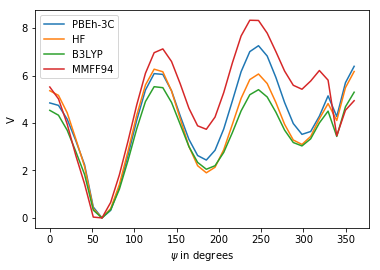

In [53]:
plt.figure()
for i in ['PBEh-3C', 'HF', 'B3LYP', 'MMFF94']:
    plt.plot(res_qc["Angle"], res_qc[i], label=i)
plt.legend()
plt.xlabel(r'$\psi$ in degrees')
plt.ylabel(r'V')
plt.savefig("scan.pdf")

In [29]:
def fit(V, phi):
    psi = phi - 180
    psi_rad = np.deg2rad(psi)
    V -= np.min(V)
    C = np.polyfit(np.cos(psi_rad), V , deg=5)
    return C

In [30]:
def V_RB(phi, C_vec):
    """
    Returns the potential (in kcal/mol) calculated using the 
    Ryckaert-Belleman formula. 
    
    Input:
        phi: Angle in degrees
    Output:
        Potential (in kcal/mol)
    """
    psi = phi - 180
    psi_rad = np.deg2rad(psi)
    cos = np.cos(psi_rad)
    p = np.poly1d(C_vec)
    V = p(cos)
    return V

In [39]:
def plot_RB(C, label):
    phi = np.linspace(0,360,100)
    plt.plot(phi, V_RB(phi, C), label=label)
    plt.xlabel(r'$\phi$ in degrees')
    plt.ylabel(r'V')

In [37]:
c_dict = {}
md_no_torsion = xyz2ff("xyz_opt", whole_energy=False)
for scf in ["B3LYP", "HF"]:
    V = res_qc[scf] - md_no_torsion
    C = fit(V, res_qc["Angle"])
    c_dict[scf] = C
    

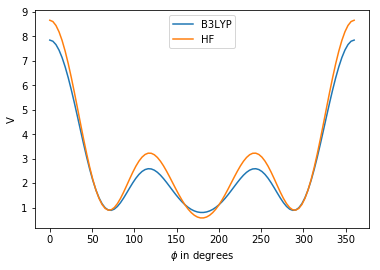

In [54]:
for key in c_dict.keys():
    plot_RB(c_dict[key], key)
plt.legend()
plt.savefig("v_rb.pdf")

In [43]:
c_df = pd.DataFrame(c_dict)

In [51]:
print(c_df)

      B3LYP        HF
0  1.563306  1.486257
1  1.668620  1.575792
2 -8.396610 -9.882902
3  1.109764  1.209000
4  3.310302  4.355467
5  1.543540  1.830176


In [49]:
c_df.to_csv("fits.csv")